<a href="https://colab.research.google.com/github/luckyyangrun/-Reservoir-flow-forecast/blob/main/baseline_ae_predictable_factors_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setups

In [ ]:
#@title install packages
import tensorflow as tf
tf.test.gpu_device_name()
!/opt/bin/nvidia-smi
# 安装环境
!pip install pytorch-lightning
!pip install numpy
!pip install pandas
!pip install torch torchvision
!pip install minetorch
!pip install matplotlib
!pip install scipy
!pip install scikit-learn
!pip install seaborn
!pip install keras
!pip install transformers
!pip install category_encoders
!pip install fastcluster
!pip install plotnine
!pip install optuna
!pip install jupyter_contrib_nbextensions
!pip install jqdatasdk
!jupyter contrib nbextension install --user
!jupyter nbextension enable codefolding/main
!pip install opencv-python-headless
!pip install PyMySQL

# 载入driver数据
# from google.colab import drive
# drive.mount('/content/drive')
!mkdir ./data
!mkdir ./src
!cp /content/drive/My\ Drive/src/utils.py ./src

In [ ]:
#@title import
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn.functional as F
import torchvision
placeholder = torch.Tensor([100, 100, 100]).cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import sys
sys.path.append('/content/src/')

%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os
from pytorch_lightning import seed_everything
set_matplotlib()
seed_everything(42)
%matplotlib inline
import gc

import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import random
from tqdm import tqdm

from scipy.stats import pearsonr, spearmanr

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Global seed set to 42


In [ ]:
#@title read and reduce memory usage
# !pip install kaggle
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/data/ubiquant/"
# %cd /content/data
# !kaggle competitions download -c ubiquant-market-prediction
# !unzip /content/data/train.csv.zip
# import pandas as pd
# import sys
# sys.path.append('/content/src/')
# from utils import *
# train = pd.read_csv('/content/data/train.csv')
# train = reduce_mem_usage(train)
# train.to_pickle("/content/drive/MyDrive/data/ubiquant/train_reduced.pkl")
!cp /content/drive/MyDrive/data/ubiquant/train_reduced.pkl /content/data/
train_all = pd.read_pickle("/content/data/train_reduced.pkl")

### Model

In [ ]:
all_tids = train_all['time_id'].unique()
all_iids = train_all['investment_id'].unique()
# 重新标下号
re_idx = {x:i for i, x in enumerate(all_iids)}
train_all['investment_id'] = train_all['investment_id'].map(re_idx)
all_iids = train_all['investment_id'].unique()

f_124, 170, 272, 200, 182, 165, 74, 102, 174在某些截面上没有方差，代表非常稀疏的事件?非常少的品种有这个特征？

训练的时候要设置一个惩罚项，惩罚factor premium的std，提升premium的可预测性，要用时间区间内的所有样本训练，不能截面std

市值加权？找找看波动率/市值的代理

In [ ]:
#@title prepare data
X = []; y = []
n_samples = 300
start = 0
for t in tqdm(all_tids[start:(start+n_samples)]):
    cross_sec = train_all.query(f"time_id=={t}")
    X.append(cross_sec.drop(['row_id', 'time_id', 'investment_id', 'target'], axis=1))
    y.append(cross_sec[['target']])

100%|██████████| 300/300 [00:11<00:00, 25.14it/s]


In [ ]:
#@title data module
class Dataset(object):
    def __init__(self, X, y, warmup=50):
        self.X = X
        self.y = y
        self.warmup = warmup

    def __len__(self):
        return len(self.X) - self.warmup

    def __getitem__(self, item):
        warmup = self.warmup
        x = self.X[item:item+warmup]
        y = self.y[item:item+warmup]
        return {
            'x': [torch.tensor(a.values, dtype=torch.float) for a in x],
            'y': [torch.tensor(a.values, dtype=torch.float) for a in y]
        }


class DataModule(pl.LightningDataModule):
    def __init__(self, X, y, warmup=5, valid_len=50):
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = 1
        self.warmup = warmup
        self.valid_len = valid_len
    
    def prepare_data(self):
        pass
    
    def setup(self, stage=None):
        # n_samples = len(self.X)
        # split_idx = int(n_samples*0.9)
        # X_train = self.X[:split_idx]; X_valid = self.X[split_idx:]
        # y_train = self.y[:split_idx]; y_valid = self.y[split_idx:]
        # print(split_idx)
        # print(len(X_train), len(X_valid))
        valid_len = self.valid_len; warmup = self.warmup
        X_train = self.X[:(-valid_len)]; X_valid = self.X[(-valid_len-warmup):]  # warmup的部分补上
        y_train = self.y[:(-valid_len)]; y_valid = self.y[(-valid_len-warmup):]
        
        self.train_dataset = Dataset(X_train, y_train, warmup)
        self.valid_dataset = Dataset(X_valid, y_valid, warmup)
        
    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=4,
            shuffle=True,
            collate_fn=lambda x: x[0]  # 这里是特殊的，必须用batch_size=1
        )
        return train_loader
        
    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=4,
            shuffle=False,
            collate_fn=lambda x: x[0]  # 这里是特殊的，必须用batch_size=1
        )
        return val_loader
        
    def test_dataloader(self):
        return None

In [ ]:
#@title Asset Pricing Net
class AssetPricingNet(pl.LightningModule):
    def __init__(self, num_feats=300, left_1=500, left_2=200, left_3=100, eps=1e-5):
        super(AssetPricingNet, self).__init__()

        self.num_feats = num_feats
        self.left_1 = left_1
        self.left_2 = left_2
        self.left_3 = left_3

        self.feature_mixer = nn.Sequential(
                                    nn.Linear(num_feats, left_1),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(left_1),
                                    nn.Dropout(0.2),
                                    nn.Linear(left_1, left_2),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(left_2),
                                    nn.Dropout(0.2),
                                    nn.Linear(left_2, left_3),
                                    nn.BatchNorm1d(left_3, affine=False)
        )

        self.constructor = nn.Sequential(
            # nn.BatchNorm1d(num_feats),
            nn.Linear(left_3, left_3),
            nn.Tanh()  # long-short, position between [-1, 1]
        )

        # eps = 1e-2
        # self.register_parameter(name='reg_mat', param=eps * torch.eye(self.num_feats))
        # self.reg_mat.requires_grad = False
        self.reg_mat = nn.Parameter(eps * torch.eye(left_3), requires_grad=False)


    def forward(self, X):
        beta = self.feature_mixer(X)
        
        barra_port = torch.matmul(torch.inverse(torch.matmul(beta.T, beta)+self.reg_mat), beta.T).T
        port = self.constructor(barra_port).T

        return beta, port

    def predict(self, X, X_hist, y_hist):
        beta = self(X)[0]
        port_hist = [self(x)[1] for x in X_hist]
        prem_hist = [torch.matmul(x, y) for x, y in zip(port_hist, y_hist)]
        prem_hat = torch.hstack(prem_hist).mean(dim=1)
        yhat = torch.matmul(beta, prem_hat)
        yhat = (yhat - yhat.mean()) / yhat.std()

        return yhat
    
    def loss(self, yhat, y):
        LOSS_FUNC = nn.MSELoss()
        # print(yhat.shape, y.shape)
        l = LOSS_FUNC(yhat.view(-1,), y.view(-1,))

        return l

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, betas=(0.99, 0.999))
        return optimizer

    def training_step(self, batch, batch_idx):
        input, target = batch['x'], batch['y']
        X_cur = input[-1]; X_hist = input[:-1]
        y_cur = target[-1]; y_hist = target[:-1]
        yhat = self.predict(X_cur, X_hist, y_hist)
        loss = self.loss(yhat, y_cur)
        logs = {'train_loss': loss}
        return {'loss': loss, 
                'log': logs, 
                'progress_bar': logs}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log("train_loss", avg_loss)
        
    def validation_step(self, batch, batch_idx):
        input, target = batch['x'], batch['y']
        X_cur = input[-1]; X_hist = input[:-1]
        y_cur = target[-1]; y_hist = target[:-1]
        yhat = self.predict(X_cur, X_hist, y_hist)
        loss = self.loss(yhat, y_cur)
        logs = {'validation_loss': loss}
        return {'loss': loss, 
                'log': logs, 
                'progress_bar': logs}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log("valid_loss", avg_loss)

In [ ]:
#@title training
BATCH_SIZE = 1
GPU = 1
EPOCHS = 1000
model = AssetPricingNet()

# logger = TensorBoardLogger('mod_logs', name='slda-test')
# %tensorboard --logdir mod_logs

checkpoint_callback = ModelCheckpoint(
    dirpath = '/content/drive/MyDrive/kaggle-ubiquant-res/',
    filename='ae-v3-{epoch}-{valid_loss:.2f}',
    save_top_k=1,
    verbose=True,
    monitor='valid_loss',
    mode='min'
)

early_stop_callback = EarlyStopping(
monitor='valid_loss',
min_delta=0.00,
patience=30,
verbose=False,
mode='min'
)

trainer = pl.Trainer(gpus=GPU, 
                    max_epochs=EPOCHS, 
                    weights_summary='full',
                    callbacks=[checkpoint_callback, early_stop_callback],
                    progress_bar_refresh_rate=40,
                    deterministic=True,
                    reload_dataloaders_every_epoch=True
                    # logger=logger
                    )

dm = DataModule(X, y)

trainer.fit(model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=40)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:188: LightningDeprecationWarning: Setting `Trainer(weights_summary=full)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.model_summary.ModelSummary` with `max_depth` directly to the Trainer's `callbacks` argument instead.
  f"Setting `Trainer(weights_summary={weights_summary})` is deprecated in v

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'progress_bar', 'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 244: valid_loss reached 43617.39062 (best 43617.39062), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=0-valid_loss=43617.39.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 489: valid_loss reached 15191.26953 (best 15191.26953), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=1-valid_loss=15191.27.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 734: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 979: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1224: valid_loss reached 3477.20435 (best 3477.20435), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=4-valid_loss=3477.20.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1469: valid_loss reached 1352.83545 (best 1352.83545), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=5-valid_loss=1352.84.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1714: valid_loss reached 616.54022 (best 616.54022), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=6-valid_loss=616.54.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1959: valid_loss reached 553.06415 (best 553.06415), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=7-valid_loss=553.06.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 2204: valid_loss reached 521.17651 (best 521.17651), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=8-valid_loss=521.18.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 2449: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 2694: valid_loss reached 505.45721 (best 505.45721), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=10-valid_loss=505.46.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 2939: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 3184: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 3429: valid_loss reached 500.38498 (best 500.38498), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=13-valid_loss=500.38.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 3674: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 3919: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 4164: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 4409: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 4654: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 4899: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 5144: valid_loss reached 384.06171 (best 384.06171), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=20-valid_loss=384.06.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 5389: valid_loss reached 288.96368 (best 288.96368), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=21-valid_loss=288.96.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 5634: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 5879: valid_loss reached 195.42816 (best 195.42816), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=23-valid_loss=195.43.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 6124: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 6369: valid_loss reached 123.04670 (best 123.04670), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=25-valid_loss=123.05.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 6614: valid_loss reached 99.35992 (best 99.35992), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=26-valid_loss=99.36.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 6859: valid_loss reached 41.83043 (best 41.83043), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=27-valid_loss=41.83.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 7104: valid_loss reached 36.25001 (best 36.25001), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=28-valid_loss=36.25.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 7349: valid_loss reached 28.60392 (best 28.60392), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=29-valid_loss=28.60.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 7594: valid_loss reached 24.71035 (best 24.71035), saving model to "/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=30-valid_loss=24.71.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 7839: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 8084: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 8329: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 8574: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 8819: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 9064: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 9309: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 9554: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 9799: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 10044: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 10289: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 10534: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 10779: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 11024: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 11269: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 11514: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 11759: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 12004: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 12249: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 50, global step 12494: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 51, global step 12739: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 52, global step 12984: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 53, global step 13229: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 54, global step 13474: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 55, global step 13719: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 56, global step 13964: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 57, global step 14209: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 58, global step 14454: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 59, global step 14699: valid_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 60, global step 14944: valid_loss was not in top 1


In [ ]:
model = AssetPricingNet.load_from_checkpoint("/content/drive/MyDrive/kaggle-ubiquant-res/ae-v3-epoch=30-valid_loss=1.53.ckpt")
dm = DataModule(X, y)
dm.setup()
VD = dm.val_dataloader()
model.eval()
yhat_col = []
ycur_col = []
metrics = []
for batch_id, batch in enumerate(VD):
    input, target = batch['x'], batch['y']
    if batch_id == 0:
      X_hist = input[:-1]; y_hist = target[:-1]
    X_cur = input[-1]; y_cur = target[-1]
    yhat = model.predict(X_cur, X_hist, y_hist).detach().numpy().reshape(-1,)
    y_cur = y_cur.detach().numpy().reshape(-1,)
    yhat_col.append(yhat)
    ycur_col.append(y_cur)
    metrics.append(pearsonr(yhat, y_cur))

In [ ]:
len(yhat_col)

50

(array([  2.,   8.,  19.,  54., 116., 215., 303., 366., 327., 243., 169.,
        113.,  75.,  60.,  39.,  28.,  23.,  23.,  24.,  19.,   9.,  15.,
          4.,   6.,   9.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.193376  , -1.9535637 , -1.7137513 , -1.473939  , -1.2341266 ,
        -0.9943142 , -0.7545018 , -0.51468945, -0.27487707, -0.0350647 ,
         0.20474768,  0.44456005,  0.6843724 ,  0.9241848 ,  1.1639972 ,
         1.4038095 ,  1.6436219 ,  1.8834343 ,  2.1232467 ,  2.363059  ,
         2.6028714 ,  2.8426838 ,  3.0824962 ,  3.3223085 ,  3.562121  ,
         3.8019333 ,  4.0417457 ,  4.281558  ,  4.5213704 ,  4.761183  ,
         5.000995  ], dtype=float32),
 <a list of 30 Patch objects>)

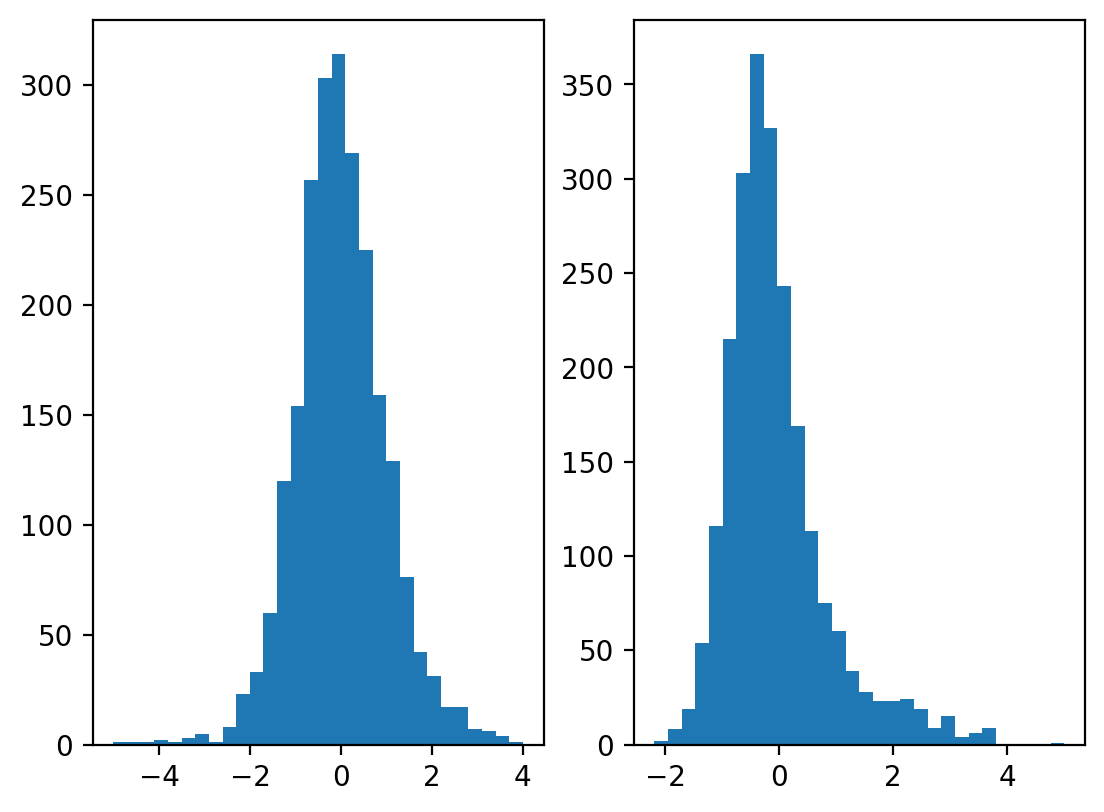

In [ ]:
s = 30
yhat = pd.Series(yhat_col[s]); ycur = pd.Series(ycur_col[s])
fig, ax = whiteboard(1, 2)
ax[0].hist(yhat, bins=30)
ax[1].hist(ycur, bins=30)

In [ ]:
y_cur

array([-0.02499343,  0.22170354,  1.0471243 , ...,  4.3431005 ,
        0.6864857 , -0.30904207], dtype=float32)

In [ ]:
np.mean([x[0] for x in metrics])

0.17560018706837166

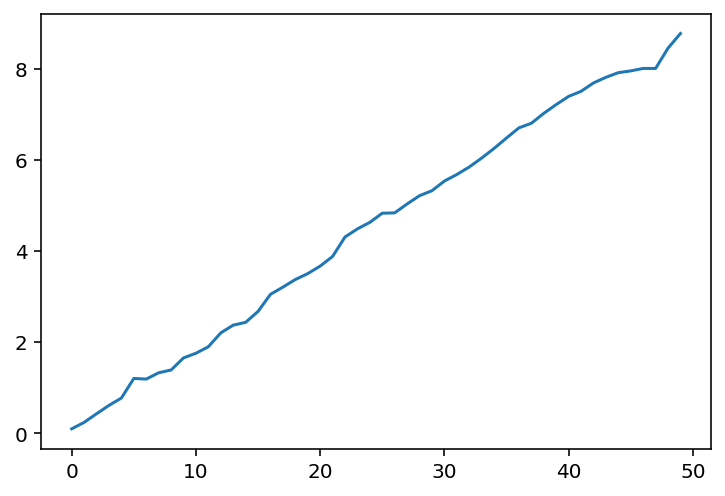

In [ ]:
pd.Series([x[0] for x in metrics]).cumsum().plot()

In [ ]:
factor_premiums = []
model.eval()
for x_, y_ in tqdm(zip(X, y)):
    x_ = torch.tensor(x_.values, dtype=torch.float); y_ = torch.tensor(y_.values, dtype=torch.float)
    beta, port = model(x_)
    prem = torch.matmul(port, y_).detach().numpy()[:, 0]
    factor_premiums.append(prem)
factor_premiums = pd.DataFrame(np.vstack(factor_premiums))


0it [00:00, ?it/s]
10it [00:00, 94.69it/s]
21it [00:00, 100.23it/s]
32it [00:00, 97.19it/s] 
42it [00:00, 91.53it/s]
52it [00:00, 93.14it/s]
62it [00:00, 93.71it/s]
73it [00:00, 96.85it/s]
83it [00:00, 97.48it/s]
93it [00:00, 97.44it/s]
105it [00:01, 101.70it/s]
116it [00:01, 92.44it/s] 
126it [00:01, 93.21it/s]
136it [00:01, 93.39it/s]
146it [00:01, 91.66it/s]
158it [00:01, 97.43it/s]
170it [00:01, 101.25it/s]
181it [00:01, 100.15it/s]
193it [00:01, 103.48it/s]
204it [00:02, 101.01it/s]
215it [00:02, 97.18it/s] 
226it [00:02, 100.53it/s]
238it [00:02, 104.04it/s]
249it [00:02, 100.33it/s]
261it [00:02, 103.61it/s]
272it [00:02, 101.12it/s]
283it [00:02, 99.83it/s] 
294it [00:02, 98.75it/s]
306it [00:03, 103.76it/s]
317it [00:03, 102.00it/s]
328it [00:03, 99.17it/s] 
340it [00:03, 104.38it/s]
351it [00:03, 104.93it/s]
362it [00:03, 104.80it/s]
374it [00:03, 108.99it/s]
387it [00:03, 113.86it/s]
399it [00:03, 111.79it/s]
411it [00:04, 112.91it/s]
423it [00:04, 113.21it/s]
435it [00:04,

In [ ]:
premium_est_window = 50
corr = []
for k in range(450, 500):
    prem_hat = factor_premiums.iloc[k-premium_est_window:k].mean()
    prem_hat = torch.tensor(prem_hat.values, dtype=torch.float)
    x_ = X[k]; y_ = y[k]
    x_ = torch.tensor(x_.values, dtype=torch.float); y_ = y_.values
    beta, port = model(x_)
    rhat = torch.matmul(beta, prem_hat).detach().numpy()
    corr.append(pearsonr(rhat, y_)[0][0])

In [ ]:
np.mean(corr)

0.00813376052863132

In [ ]:
np.sqrt(len(factor_premiums)) * factor_premiums.mean() / factor_premiums.std()

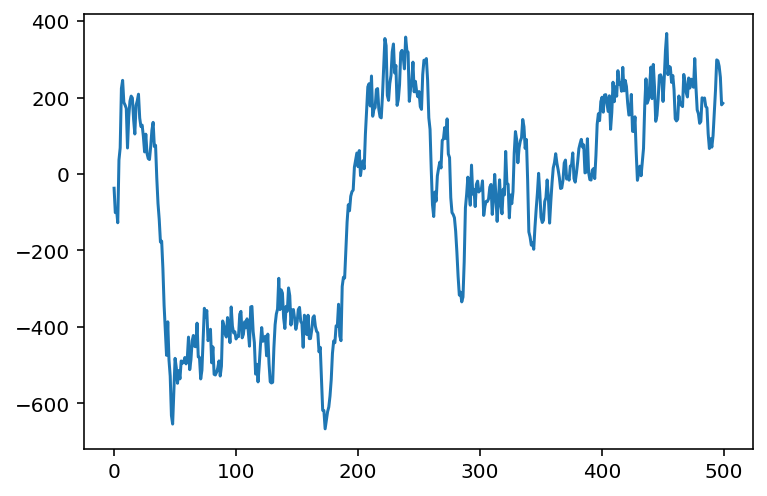

In [ ]:
factor_premiums[20].cumsum().plot()